In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
general=dd.read_csv('General_Payments.csv',dtype='str',low_memory=False)
research=dd.read_csv('Research_Payments.csv',dtype='str',low_memory=False)
research['Type']='1'
general['Type']='0'

In [176]:
#Only taking columns common in both files to eliminate leaky columns.
cc=research.columns.intersection(general.columns)
cc_list=list(cc)
r=research[cc_list].compute()
g=general[cc_list].compute()

In [326]:
from random import sample
np.random.seed(0)
rindex=np.array(sample(range(len(r)),5000))
r1=r.iloc[rindex]
gindex=np.array(sample(range(len(g)),5000))
g1=g.iloc[gindex]
final=pd.concat([r1,g1])
final1=final.copy()
final_shuffled1=final1.sample(frac=1)


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 10467 to 50553
Data columns (total 65 columns):
Change_Type                                                         10000 non-null object
Covered_Recipient_Type                                              10000 non-null object
Teaching_Hospital_CCN                                               787 non-null object
Teaching_Hospital_ID                                                787 non-null object
Teaching_Hospital_Name                                              787 non-null object
Physician_Profile_ID                                                5176 non-null object
Physician_First_Name                                                5176 non-null object
Physician_Middle_Name                                               3049 non-null object
Physician_Last_Name                                                 5176 non-null object
Physician_Name_Suffix                                               133 non-null object

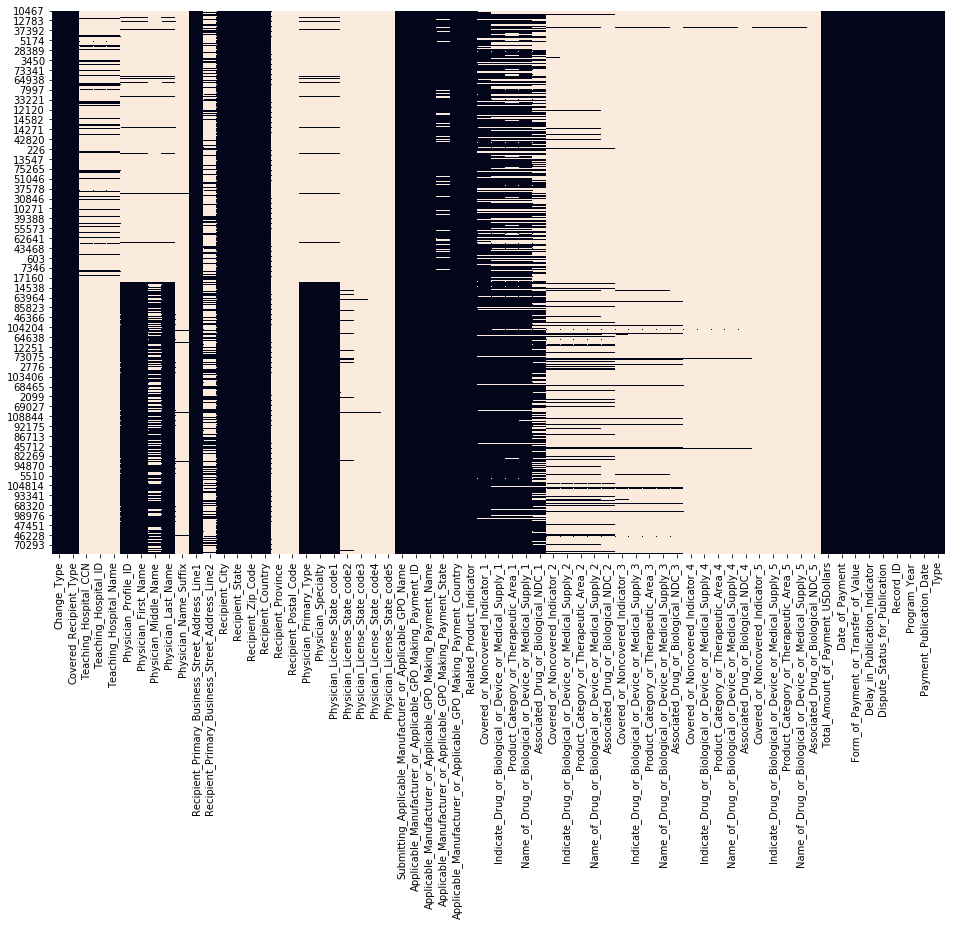

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(16,10))
ax=sns.heatmap(final.isnull(), cbar=False)

In [327]:
dropped_columns=[2,3,4,5,6,7,8,9,16,17,18,19,20,21,22,23,24,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55]
final.drop(final.columns[dropped_columns],axis=1,inplace=True)

In [330]:
final_shuffled=final.sample(frac=1)
y=final_shuffled.iloc[:,27]
X=final_shuffled.iloc[:,:27]

In [331]:
X['Total_Amount_of_Payment_USDollars']=X['Total_Amount_of_Payment_USDollars'].astype('float64')
X1=X.copy()
X1.fillna('N',inplace=True)

In [28]:
from collections import Counter
import math
import scipy.stats as ss
import matplotlib.pyplot as plt
def conditional_entropy(x, y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [332]:
final_shuffled.fillna("N",inplace=True)

In [45]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
cramers=np.empty((28,28))
for i in range(len(final_shuffled.columns)):
    for j in range(len(final_shuffled.columns)):
        confusion_matrix = pd.crosstab(final_shuffled.iloc[:,i], final_shuffled.iloc[:,j]).as_matrix()
        cramers[i][j]=cramers_v(confusion_matrix)

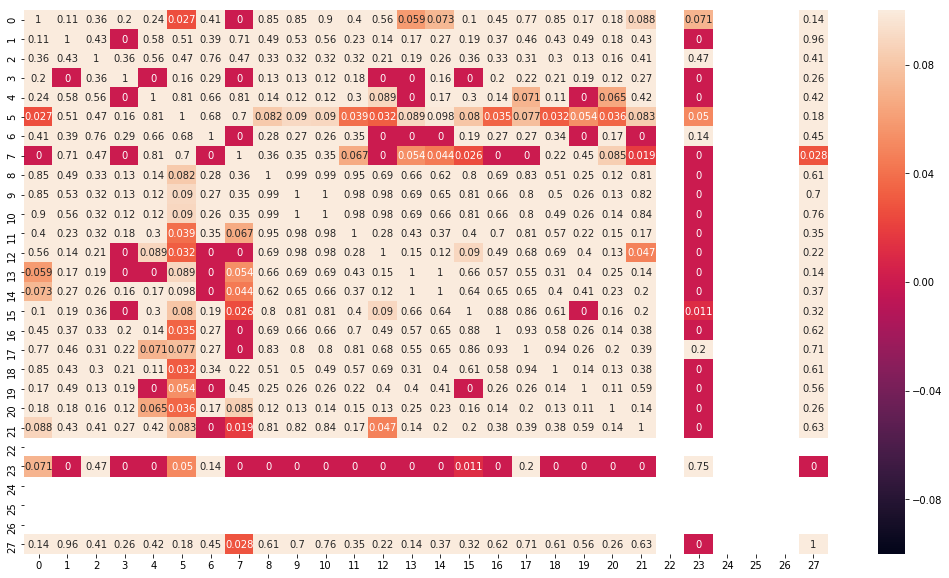

In [53]:
cramers
fig,ax=plt.subplots(figsize=(18,10))
ax=sns.heatmap(cramers,annot=True)

In [170]:
#0,1,8,9,10,11,12,15,16,17,18,19,22,24,25,26
cols=[0,1,8,9,10,11,12,14,15,16,17,18,19,22,24,25,26]
fin1=final_shuffled.copy()
fin1.drop(fin1.columns[cols],axis=1,inplace=True)

In [171]:
#fin1['Total_Amount_of_Payment_USDollars']=fin1['Total_Amount_of_Payment_USDollars'].astype('float64')

In [172]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
X1=fin1.iloc[:,:10]
y=fin1.iloc[:,10]
categorical=X1.dtypes==object
X1_train,X1_test,y_train,y_test=train_test_split(X1,y)
categorical = X1.dtypes == object
preprocess = make_column_transformer((StandardScaler(), ~categorical),
                                     (OneHotEncoder(handle_unknown='ignore'), categorical))
model = make_pipeline(preprocess, LogisticRegression())
scores = cross_val_score(model, X1_train, y_train, cv=10)
np.mean(scores), np.std(scores)


(0.8409330377476225, 0.013871861016444331)

In [116]:
X1.columns

Index(['Recipient_Primary_Business_Street_Address_Line1',
       'Recipient_Primary_Business_Street_Address_Line2', 'Recipient_City',
       'Recipient_State', 'Recipient_Zip_Code', 'Recipient_Country',
       'Related_Product_Indicator', 'Covered_or_Noncovered_Indicator_1',
       'Date_of_Payment', 'Form_of_Payment_or_Transfer_of_Value',
       'Dispute_Status_for_Publication'],
      dtype='object')

### Task 3

In [ ]:
dropped_columns1=[2,3,4,5,6,7,8,9,16,17,21,22,23,24,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55]
final_shuffled1.drop(final_shuffled1.columns[dropped_columns1],axis=1,inplace=True)
y2=final_shuffled1.iloc[:,27]
X2=final_shuffled1.iloc[:,:27]

In [239]:
final_shuffled1.columns

Index(['Change_Type', 'Covered_Recipient_Type',
       'Recipient_Primary_Business_Street_Address_Line1',
       'Recipient_Primary_Business_Street_Address_Line2', 'Recipient_City',
       'Recipient_State', 'Recipient_Zip_Code', 'Recipient_Country',
       'Physician_Primary_Type', 'Physician_Specialty',
       'Physician_License_State_code1',
       'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Related_Product_Indicator', 'Covered_or_Noncovered_Indicator_1',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Product_Category_or_Therapeutic_Area_1',
       'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Associated_Drug_or_Biological_

In [182]:
final_shuffled1.Payment_Publication_Date.value_counts()
#29

01/18/2019    10000
Name: Payment_Publication_Date, dtype: int64

In [183]:
final_shuffled1.Program_Year.value_counts()
#28

2017    10000
Name: Program_Year, dtype: int64

In [184]:
len(final_shuffled1.Record_ID.unique())
#27

10000

In [185]:
final_shuffled1.Dispute_Status_for_Publication.value_counts()
#26

No     9998
Yes       2
Name: Dispute_Status_for_Publication, dtype: int64

In [186]:
final_shuffled1.Delay_in_Publication_Indicator.value_counts()
#25

No    10000
Name: Delay_in_Publication_Indicator, dtype: int64

In [240]:
#Dropping Line1,Line2
#2,3
cols=[2,3,25,26,27,28,29]
final_shuffled1.drop(final_shuffled1.columns[cols],axis=1,inplace=True)

In [241]:
final_shuffled1.columns[10]

'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'

In [242]:
final_shuffled1.fillna('N',inplace=True)

In [243]:
#data cleaning
#replacing NA in country by United States (most frequent)
final_shuffled1.Recipient_Country.replace('N','United States',inplace=True)
final_shuffled1['Recipient_Zip_Code']=final_shuffled1['Recipient_Zip_Code'].str.split("-").str[0]
final_shuffled1['Physician_Specialty']=final_shuffled1['Physician_Specialty'].str.split("|").str[0]


In [244]:
final_shuffled1['Total_Amount_of_Payment_USDollars']=final_shuffled1['Total_Amount_of_Payment_USDollars'].astype('float64')
cols=[1,10]
final_shuffled1.drop(final_shuffled1.columns[cols],axis=1,inplace=True)


(0.9816012323577464, 0.004287172277278367)

In [277]:
final_shuffled1.columns[10]

'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State'

In [285]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
cramers1=np.empty((22,22))
for i in range(len(final_shuffled1.columns)):
    for j in range(len(final_shuffled1.columns)):
        confusion_matrix = pd.crosstab(final_shuffled1.iloc[:,i], final_shuffled1.iloc[:,j]).as_matrix()
        cramers1[i][j]=cramers_v(confusion_matrix)

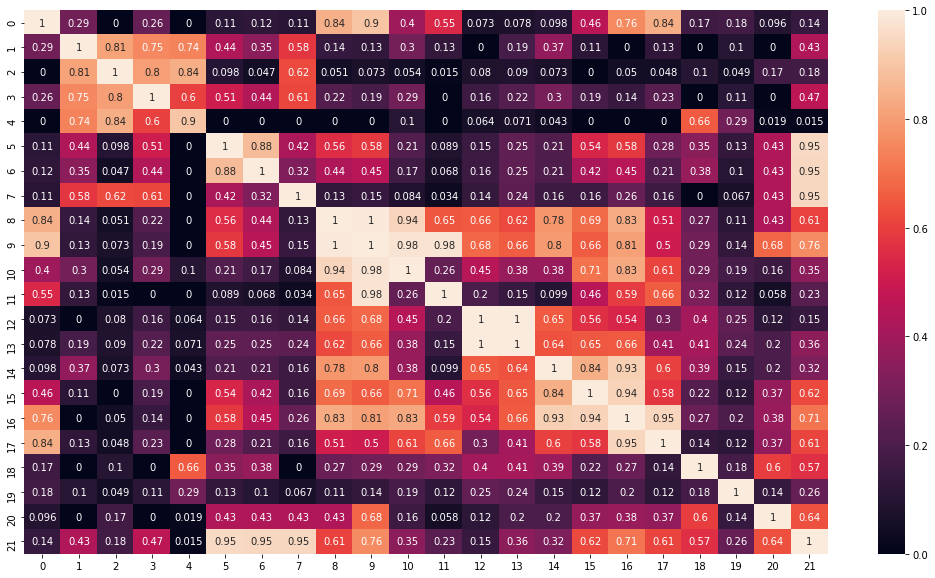

In [286]:
fig,ax=plt.subplots(figsize=(18,10))
ax=sns.heatmap(cramers1,annot=True)

In [320]:
final_shuffled2=final_shuffled1.copy()
cols=[5,6,7,8,9,12,13,14,15,16,17]
final_shuffled2.drop(final_shuffled2.columns[cols],axis=1,inplace=True)
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
X2=final_shuffled2.iloc[:,:10]
y2=final_shuffled2.iloc[:,10]
categorical=X2.dtypes==object
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2)
preprocess = make_column_transformer((StandardScaler(), ~categorical),
                                     (OneHotEncoder(handle_unknown='ignore'), categorical))
model = make_pipeline(preprocess, LogisticRegression())
scores = cross_val_score(model, X2_train, y2_train, cv=10)
np.mean(scores), np.std(scores)


(0.8870655236720421, 0.011184988538826773)

In [539]:
fin3=final_shuffled.copy()

In [540]:
fin3['Total_Amount_of_Payment_USDollars']=fin3['Total_Amount_of_Payment_USDollars'].astype('float64')

In [541]:
fin3.fillna("N",inplace=True)
cols=[22,24,25,26]
fin3.drop(fin3.columns[cols],axis=1,inplace=True)

In [410]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
cramers3=np.empty((24,24))
for i in range(len(fin3.columns)):
    for j in range(len(fin3.columns)):
        confusion_matrix = pd.crosstab(fin3.iloc[:,i], fin3.iloc[:,j]).as_matrix()
        cramers3[i][j]=cramers_v(confusion_matrix)

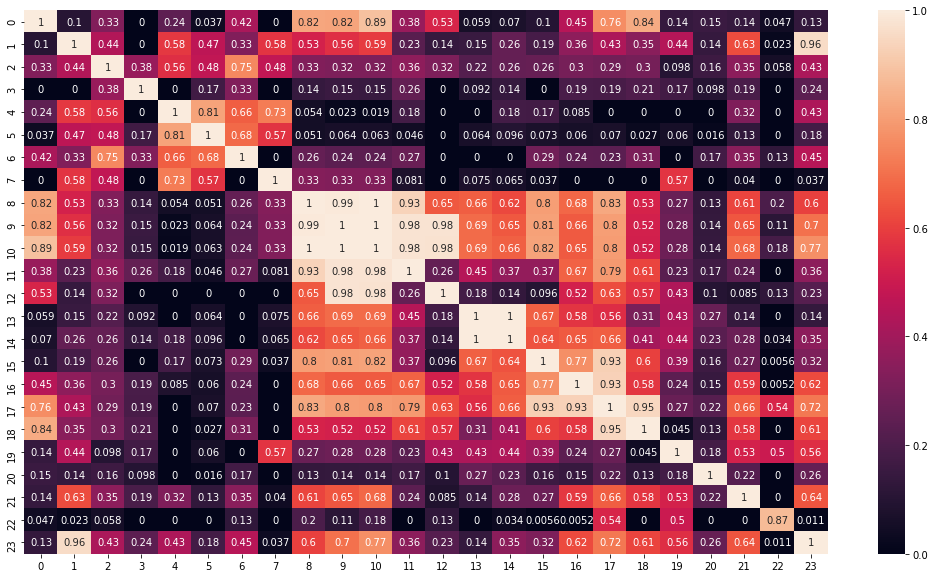

In [411]:
fig,ax=plt.subplots(figsize=(18,10))
ax=sns.heatmap(cramers3,annot=True)

In [542]:
cols=[1,8,9,10,13,15,16,17,18]
fin3.drop(fin3.columns[cols],axis=1,inplace=True)
fin3.drop(fin3.columns[11],axis=1,inplace=True)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
X3=fin3.iloc[:,:13]
y3=fin3.iloc[:,13]
y3=y3.astype('int64')
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, stratify=y3, random_state=0)
categorical=X3.dtypes==object
preprocess = make_column_transformer((StandardScaler(), ~categorical),
                                     (OneHotEncoder(handle_unknown='ignore'), categorical))
model = make_pipeline(preprocess,DecisionTreeClassifier(criterion='entropy',max_depth=4))
model.fit(X3_train,y3_train)
scores=cross_val_score(model,X3_train,y3_train,cv=10)
np.mean(scores)

0.8944000000000001

In [496]:
#Grid Search
model1 = make_pipeline(preprocess,DecisionTreeClassifier(criterion='entropy'))
param_grid = {'decisiontreeclassifier__max_depth':range(1, 7),'decisiontreeclassifier__max_leaf_nodes':range(2, 11)}
search = GridSearchCV(model, param_grid, cv=10,return_train_score=True)
search.fit(X3_train, y3_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True), Change_Type                                                      ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontreeclassifier__max_depth': range(1, 7), 'decisiontreeclassifier__max_leaf_nodes': range(2, 11)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [497]:
print(search.best_score_)
print(search.best_params_)

0.9037333333333334
{'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__max_leaf_nodes': 10}


In [498]:
model2 = make_pipeline(preprocess,DecisionTreeClassifier(criterion='entropy',max_depth=4,max_leaf_nodes=10))
scores=cross_val_score(model2,X3_train,y3_train,cv=10)
model2.fit(X3_train,y3_train)
np.mean(scores)

0.9037333333333333

In [518]:
from sklearn.metrics import accuracy_score
y_pred=model2.predict(X3_test)
acc=accuracy_score(y3_test,y_pred)
acc

0.9096

In [519]:
fin3.columns

Index(['Change_Type', 'Recipient_Primary_Business_Street_Address_Line1',
       'Recipient_Primary_Business_Street_Address_Line2', 'Recipient_City',
       'Recipient_State', 'Recipient_Zip_Code', 'Recipient_Country',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Covered_or_Noncovered_Indicator_1',
       'Total_Amount_of_Payment_USDollars',
       'Form_of_Payment_or_Transfer_of_Value',
       'Dispute_Status_for_Publication', 'Type'],
      dtype='object')

In [543]:
cols=[1,2]
fin3.drop(fin3.columns[cols],axis=1,inplace=True)
X3=fin3.iloc[:,:11]
y3=fin3.iloc[:,11]
y3=y3.astype('int64')
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, stratify=y3, random_state=0)
categorical=X3.dtypes==object
preprocess = make_column_transformer((StandardScaler(), ~categorical),
                                     (OneHotEncoder(handle_unknown='ignore'), categorical))
model = make_pipeline(preprocess,DecisionTreeClassifier(criterion='entropy',max_depth=4))
model.fit(X3_train,y3_train)
scores=cross_val_score(model,X3_train,y3_train,cv=10)
np.mean(scores)

0.8944000000000001

In [628]:
ohe=OneHotEncoder()
cat=[0,1,2,3,4,5,6,7,9,10]
categorical_data=X3_train.iloc[:,cat]
encoded=ohe.fit_transform(categorical_data)
stc=StandardScaler()

In [581]:
features = ['Total Amount']+model.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names().tolist()

In [630]:
a=np.hstack((encoded.toarray(),stc.fit_transform(np.array(X3_train.iloc[:,8]).reshape(-1,1))))

In [631]:
a.shape

(7500, 6602)

0.9056162082278526
0.9096


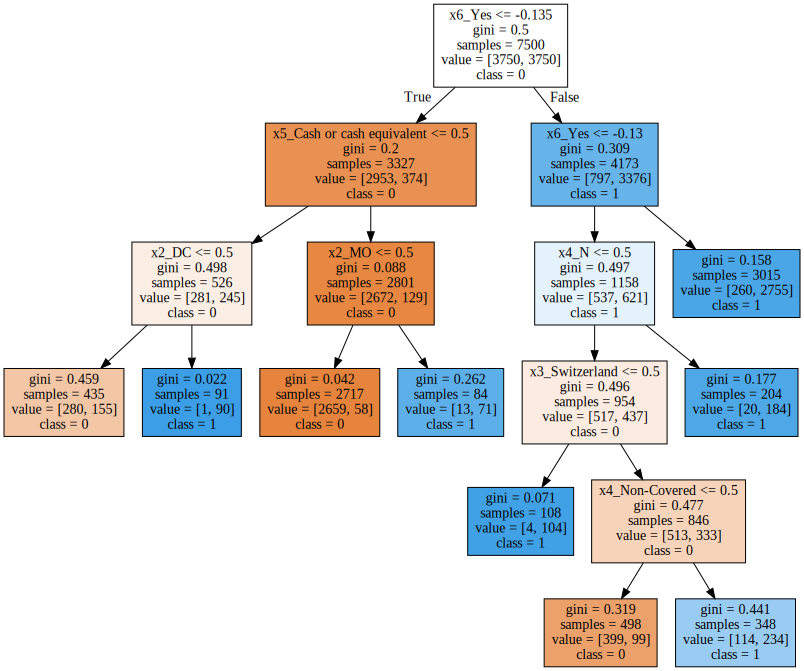

In [652]:
X4=X3.copy()
cols=[1,2,3]
X4.drop(X4.columns[cols],axis=1,inplace=True)
X4_train, X4_test, y3_train, y3_test = train_test_split(X4, y3, stratify=y3, random_state=0)
ohe=OneHotEncoder()
cat=[0,1,2,3,4,6,7]
categorical_data=X4_train.iloc[:,cat]
ohe=OneHotEncoder()
encoded=ohe.fit_transform(categorical_data)
stc=StandardScaler()
a=np.hstack((encoded.toarray(),stc.fit_transform(np.array(X4_train.iloc[:,5]).reshape(-1,1))))
categorical=X4.dtypes==object
preprocess = make_column_transformer((StandardScaler(), ~categorical),
                                     (OneHotEncoder(handle_unknown='ignore'), categorical))
model = make_pipeline(preprocess,DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=9))
model.fit(X4_train,y3_train)
scores=cross_val_score(model,X4_train,y3_train,scoring='average_precision',cv=10)
print(np.mean(scores))
y_pred=model.predict(X4_test)
acc=accuracy_score(y3_test,y_pred)
print(acc)
features = ['Total Amount']+model.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names().tolist()
from sklearn.tree import export_graphviz,DecisionTreeClassifier
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
estimator=DecisionTreeClassifier(max_leaf_nodes=9)
estimator.fit(a, y3_train)
graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=features, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [653]:
len(X3.columns)

11